In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
import functools as ft
import scipy.sparse as sparse
import scipy.sparse.linalg as spsl

## Some comments:
- This exercise is due on March 3rd.
- Not all information you will need is necessarily given in the sheet. It is expected that you will make use of the the library documentation when solving these tasks. 
- In a jupyter notebook, you can access the docstring of a function by typing its name (e.g. "np.array") and then pressing tab while holding down the shift key. 
- Note that I have defined the transverse field Ising model Hamiltonian differently from how it was defined in the lectures.
- Part 4 is voluntary. You can get full marks on the exercise without doing this part.

# Exact diagonalisation (ED)

The aim of this exercise is to implement exact diagonalisation to find the eigenvalues and eigenvectors of a quantum Hamiltonian.

We will focus on the transverse field Ising model on a 1D chain of N spin-$\frac{1}{2}$ particles:

$$ {\cal H}_{\mathrm{Ising}} = -J \sum_{i=1}^N \sigma_i^z \sigma_{i+1}^z - h \sum_i \sigma_i^x$$

Here $\sigma_i^\alpha$ are the familiar Pauli matrix operators for spin i on the chain:

$$ \sigma^x = \begin{pmatrix}
0 & 1 \\
1 & 0 \end{pmatrix} \, , 
\sigma^y = \begin{pmatrix}
0 & -i\\
i & 0
\end{pmatrix} \, , 
\sigma^z = \begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
\ 
$$

We will assume $J=1$ and work with periodic boundary conditions by assumming that $\sigma_{N+1} = \sigma_1$. For periodic boundary conditions the groundstate energy at $h=1$ is known exactly to be
$$ E_0(h=1) = -\frac{2}{\sin{\left(\frac{\pi}{2N}\right)}}$$
which you can use to test your code.


The next step is to split this Hamiltonian into a sum of local terms, centred on the bonds between spins:
$$ {\cal H}_{\mathrm{Ising}} = \sum_{i=1}^N {\cal H}_{i, i+1}^{\mathrm{loc}} $$
with
$$ {\cal H}_{i,i+1}^{\mathrm{loc}} = - \sigma_i^z \sigma_{i+1}^z + \frac{1}{2}h(\sigma_i^x + \sigma_{i+1}^x)$$.




## Part 1: Constructing the Hamiltonian matrix explicitly

We will be working in the basis of states given by 
$$|1\rangle = |\uparrow \uparrow \uparrow ... \uparrow \uparrow \rangle $$
$$|2\rangle = |\uparrow \uparrow \uparrow ... \uparrow \downarrow \rangle $$
$$|3\rangle = |\uparrow \uparrow \uparrow ... \downarrow \uparrow \rangle $$
$$ . $$
$$ . $$ 
$$ . $$
$$|N+2\rangle = |\uparrow \uparrow \uparrow ... \uparrow \downarrow \downarrow \rangle $$
$$|N+3\rangle = |\uparrow \uparrow \uparrow ... \downarrow \uparrow \downarrow \rangle $$

$$ . $$
$$ . $$ 
$$ . $$
$$|2^N\rangle = |\downarrow \downarrow \downarrow ... \downarrow \uparrow \rangle $$
$$|2^N\rangle = |\downarrow \downarrow \downarrow ... \downarrow \downarrow \rangle $$


Our states are expressed as 
$$ | \psi \rangle = \sum_{n=1}^{2^N} c_n|n \rangle $$
and the coefficients $c_n$ can be expressed as a vector $\mathbf{n}$ with $2^N$ components. The first thing we have to do is now to rewrite the Hamiltonian as a $2^N \times 2^N$ matrix $H$, using our local Hamiltonians ${\cal H}_{i, i+1}^{\mathrm{loc}}$. $H$ is defined by 
$$H_{m, n} = \langle m | {\cal H}_{\mathrm{Ising}} | n \rangle $$
but we can construct it directly from our Pauli matrices. 

To do this, we need to include the identities that are implicit in the Hamiltonian above. It should really read:


$$ {\cal H}_{\mathrm{Ising}} = - \sum_{i=1}^N I_1...I_{i-1}\sigma_i^z \sigma_{i+1}^zI_{i+2}...I_N - h \sum_i I_1...I_{i-1}\sigma_i^x I_{i+1}...I_N$$

We build up our matrix by taking the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of the Pauli matrices. This is most easily done using the np.kron function in numpy. 

Rather than nesting a large number of np.kron(...) calls in our code, we can make use of the functools library function reduce.

For example: ft.reduce(np.kron, [A, B, C, D]) = np.kron(np.kron(np.kron(A, B), C), D)

The function CompleteHamiltonian defined below computes the Hamiltonian matrix for a system with $N$ spins.

In [2]:
# Define our Pauli Matrices

I = np.array([[1, 0], [0, 1]])
sigmaX = np.array([[0, 1],[1, 0]])
sigmaZ = np.array([[1, 0], [0, -1]])

In [3]:
def CompleteHamiltonian(N, h=1.):
    """
    Constructs the Hamiltonian matrix of the transverse field Ising model for a system of N spins using periodic boundary conditions and in a transverse field h.
    Does this using Kronecker products of the Pauli matrices.
    Stores the Hamiltonian matrix in a numpy.ndarray object.
    
    Parameters:
    -----------
    N: integer
    h: float type, optional
    
    Returns:
    -----------
    H: ndarray
    
    """
    Matrices1 = np.zeros((N, 2, 2))
    Matrices1[:] = I
    Matrices2 = np.copy(Matrices1)
    Matrices1[0] = sigmaZ
    Matrices1[1] = sigmaZ

    Matrices2[0] = h * sigmaX
    
    
    H = np.zeros((2**N, 2**N))
    for ii in range(N):
        H -= ft.reduce(np.kron, Matrices1)
        Matrices1 = np.roll(Matrices1, 1, axis=0)
        
        H -= ft.reduce(np.kron, Matrices2)
        Matrices2 = np.roll(Matrices2, 1, axis=0)
        
    
    return H


In [ ]:
CompleteHamiltonian(2)

array([[-2., -1., -1.,  0.],
       [-1.,  2.,  0., -1.],
       [-1.,  0.,  2., -1.],
       [ 0., -1., -1., -2.]])

### Task 1:
Construct ${\cal H}^{\mathrm{loc}}$ as a $4\times 4$ numpy array Hloc using Kronecker products of the Pauli matrices and the identity.

In [4]:
def LocalHamiltonian(h):
    # Your code goes here
    Hloc = -np.kron(sigmaZ, sigmaZ) - (1/2) * h * (np.kron(sigmaX, I) + np.kron(I, sigmaX))
    return Hloc

In [ ]:
LocalHamiltonian(1)

array([[-1. , -0.5, -0.5,  0. ],
       [-0.5,  1. ,  0. , -0.5],
       [-0.5,  0. ,  1. , -0.5],
       [ 0. , -0.5, -0.5, -1. ]])

The result should be:
$$H^{\mathrm{loc}} =  \begin{pmatrix}
-1 & -h/2 & -h/2 & 0 \\
-h/2 & 1 & 0 & -h/2 \\
-h/2 & 0 & 1 & -h/2 \\
0 & -h/2 & -h/2 & -1 \end{pmatrix}$$


### Task 2:
Write a function "CompleteHamiltonian2" that uses $H^{\mathrm{loc}}$ to iteratively construct the complete Hamiltonian. You can make use of the fact that the Kronecker product of two identity matrices with shapes $M\times M$ and $N\times N$ is an identity matrix of shape $(M+N) \times (M+N)$. Don't forget about the periodic boundary conditions (for these you may want to use the elementary Pauli matrices), and make sure to check that your function does the same thing as the example above.

In [5]:
def CompleteHamiltonian2(N, h=1.):
    # Your code goes here.
    H = np.zeros((2**N, 2**N))
    for i in range(N-1):
      H += ft.reduce(np.kron, [np.identity(2**i), LocalHamiltonian(h), np.identity(2**(N-i-2))]) 
    H += -ft.reduce(np.kron, [sigmaZ, np.identity(2**(N-2)), sigmaZ]) - (1/2) * h * np.kron(np.identity(2**(N-1)), sigmaX) - (1/2) * h * np.kron(sigmaX, np.identity(2**(N-1))) 
    return H

In [ ]:
CompleteHamiltonian(2)

array([[-2., -1., -1.,  0.],
       [-1.,  2.,  0., -1.],
       [-1.,  0.,  2., -1.],
       [ 0., -1., -1., -2.]])

In [ ]:
# Check that the two methods do the same thing.
np.all(np.isclose(CompleteHamiltonian(10, h = 1.23), CompleteHamiltonian2(10, h = 1.23)))

True

If you are struggling to write a function to construc the Hamiltonian using ${\cal H}^{\mathrm{loc}}$ you can continue using the function CompleteHamiltonian in the following tasks.

Now that we have a way to construct our Hamiltonian matrices we can diagonalise these to find the energy groundstate. 

### Task 3:
Use the eigh function in numpy.linalg to find the eigenvalues of the Hamiltonian. Plot the groundstate energy as a function of $h$ for $h$ between 0.01 and 100. Do this for a few different values of $N<10$ and normalise by $N$. I would suggest using a log-log scale (e.g. using plt.xscale('log') and plt.yscale('symlog')). Do the energies for $h << 1$ and $h >> 1$ match your expectation?

In [ ]:
np.linalg.eig(CompleteHamiltonian2(2))[0]

array([-2.82842712, -2.        ,  2.82842712,  2.        ])

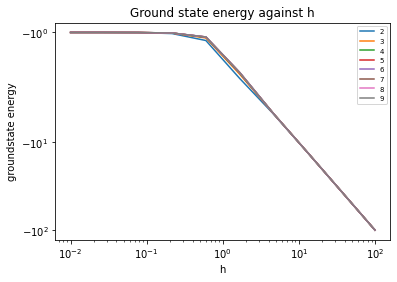

In [9]:
hh = np.logspace(-2, 2, 10)
Ns = np.arange(2, 10, 1)

# Your code goes here
for N in Ns:
  E = []
  for h in hh:
    H = CompleteHamiltonian2(N, h)
    E.append(npl.eigh(H)[0][0]/N)
  plt.plot(hh, E, label=str(N))
  plt.legend(prop={'size': 7})
  plt.title('Ground state energy against h')
  plt.xlabel('h')
  plt.ylabel('groundstate energy')
  plt.xscale('log')
  plt.yscale('symlog')

When $h << 1$, the Ising model is in ordered phase with degenerate ground state space. When h=0, the system is (with probability one) in the first basis state, where all spins point in z direction.
In contrast, when $h >> 1$ the system is said to be in the disordered phase. The ground state is nondegenerate. And the system occupies all basis states with approximately equal probability (maximal superposition).

As you have probably already realised, this method quickly becomes very expensive as we go to larger $N$. Let's explore this a bit further. 

### Task 4:
Use the code below to measure how the computational time scales for your function. Plot this as a function of $N$ for $N<=10$, and include the standard deviation as an errorbar. 


In [ ]:
Ns = np.arange(2, 11, 1)
h = 1

timingCompact = []
for N in Ns:
    print(f"N={N}")
    result = %timeit -o npl.eigh(CompleteHamiltonian2(N))
    timingCompact.append(result)

# The averages can be put in a list by doing: [time.average for time in timingCompact]
# Same for the standard deviation: [time.stdev for time in timingCompact]

N=2
942 µs ± 344 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
N=3
2.35 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=4
3.95 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=5
5.89 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=6
3.19 ms ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=7
9.09 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=8
21.4 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N=9
111 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N=10
485 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, 'Computational time')

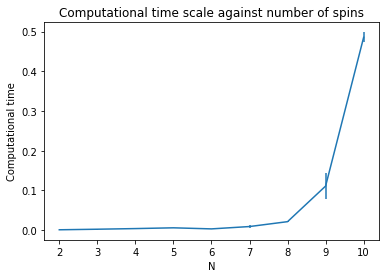

In [ ]:
# Plot the result here. Use a log-scale for the y-axis.
plt.errorbar(Ns, [time.average for time in timingCompact], [time.stdev for time in timingCompact])
plt.title('Computational time scale against number of spins')
plt.xlabel('N')
plt.ylabel('Computational time')

Clearly, this scales quite poorly in terms of computation time, and we will soon run into problems. In addition, storing the $2^N \times 2^N$ matrix quickly becomes infeasible (although the memory usage is slightly trickier to measure directly in python).

To progress, we will make use of an important property of the Hamiltonian – that it is a sparse matrix. 

## Part 2: Using sparse matrices and solvers

In this part of the exercises we will make use of the built-in functionality to deal with sparse matrices available in scipy.sparse and scipy.sparse.linalg. 

To define a sparse version of a numpy.ndarray object A simply use sparseA = sparse.csr_matrix(A). This creates a "Compressed Sparse Row array".  You could also try using sparse.csc_matrix, "Compressed Sparse Column array", and check if there is a difference in performance between the two. (This check is not a required task!) 

scipy.sparse.kron provides a sparse version of the Kronecker product. 

scipy.sparse.identity provides a sparse version of the identity. 

In [ ]:
result_csr = %timeit -o npl.eigh(I)
print('csr:', result_csr)
result_csc = %timeit -o npl.eigh(I)
print('csc', result_csc)

11.4 µs ± 2.62 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
csr: 11.4 µs ± 2.62 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.1 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
csc 10.1 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


compressed sparse row array is generally less time consuming than column matrix in the case of matrix with scales like Identity.

### Task 5:
Rewrite your code from task 2 to construct a sparse representation of the Hamiltonian. 

Remember not to create any large regular matrices (i.e. a matrix/array with all elements stored in memory) in the process! 

In [ ]:
sparse.csr_matrix(I)

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
# Define our Pauli Matrices

sparseI = sparse.csr_matrix(I)
sparseX = sparse.csr_matrix(sigmaX)
sparseZ = sparse.csr_matrix(sigmaZ)

# Use these to construct the Hamiltonian. 

def SparseHamiltonian(N, h=1):
    def LocalHamiltonian_sparse(h):
      # Your code goes here
      Hloc = -sparse.kron(sparseZ, sparseZ) - (1/2) * h * (sparse.kron(sparseX, sparseI) + sparse.kron(sparseI, sparseX))
      return Hloc
    # Your code goes here
    H = sparse.csr_matrix(np.zeros((2**N, 2**N)))
    for i in range(N-1):
      H += ft.reduce(sparse.kron, [sparse.identity(2**i), LocalHamiltonian_sparse(h), sparse.identity(2**(N-i-2))]) 
    H += -ft.reduce(sparse.kron, [sparseZ, sparse.identity(2**(N-2)), sparseZ]) - (1/2) * h * sparse.kron(sparse.identity(2**(N-1)), sparseX) - (1/2) * h * sparse.kron(sparseX, sparse.identity(2**(N-1))) 
    return H

In [ ]:
# Check that your Hamiltonian is really a sparse object:
type(SparseHamiltonian(10))

scipy.sparse.csr.csr_matrix

### Task 6:
How many elements are we explicitly storing in our Hamiltonian matrix? Plot the number of explicitly stored elements as a function of N. Also plot the total number of elements that there would have been in the complete matrix. You should be able to go to at least $N=16$ now.

The number of elements in a sparse matrix A is given by calling A.nnz

In [ ]:
CompleteHamiltonian2(2).size

16

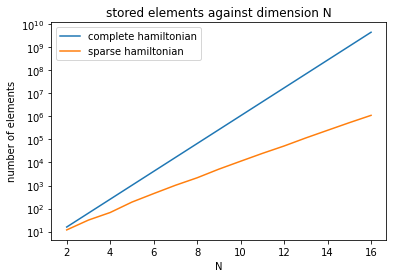

In [ ]:
Ns = np.arange(2, 17, 1)
e = np.zeros((2,len(Ns)))
for i in range(len(Ns)):
  e[0][i] = 2**(2*Ns[i])
  e[1][i] = SparseHamiltonian(Ns[i]).nnz

plt.plot(Ns, e[0], label='complete hamiltonian')
plt.plot(Ns, e[1], label='sparse hamiltonian')
plt.title('stored elements against dimension N')
plt.xlabel('N')
plt.ylabel('number of elements')
plt.yscale('symlog')
plt.legend()
plt.show()

sparse matrix has much less elements needed to be stored compared to complete hamiltonian.

## Part 3: Using a linear operator to define your matrix


The LinearOperator class in scipy.sparse.linalg defines a "matrix-like" object $A$ based on how it operates on a vector $\mathbf{v}$, i.e. from the equation $A\mathbf{v} = \mathbf{c}$. It is called with two inputs: shape (in our case the tuple ($2^N$, $2^N$)) and a callable "matvec", which in our case will be a function "ActWithH(psi)".

We do not want to do this by constructing the $2^N \times 2^N$ matrix version of ${\cal H}^{\mathrm{loc}}$. We are trying to reduce memory usage, so that would defeat the purpose.

### Task 7: 
We need a function that performs the action of ${\cal H}_{\mathrm{Ising}}$ on a general state, encoded in a vector of length $2^N$. Define a function that does this through repeated operation with ${\cal H}^{\mathrm{loc}}$.

You should make use of the property that the operation on a general state, stored in a $2^N$ vector $|\psi \rangle $, by ${\cal H}^{\mathrm{loc}}_{i,i+1}$ can be computed efficiently using a tensor product as demonstrated in the lectures. (In fact, the simplest solution here would be to rewrite the code given in the lecture notes to use your Hloc.)

In [ ]:
def ActWithH(psiIn, N, h=1.):
    
    hloc = LocalHamiltonian(h).reshape((2,2,2,2))
    d = hloc.shape[0]
    psiOut = np.zeros(psiIn.size)
    for k in range(N - 1):
    # apply local Hamiltonian terms to sites [k,k+1]
        psiOut += np.tensordot(hloc.reshape(d**2, d**2),
                           psiIn.reshape(d**k, d**2, d**(N - 2 - k)),
                           axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)

    # apply periodic term
    psiOut += np.tensordot(hloc.reshape(d, d, d, d),
                           psiIn.reshape(d, d**(N - 2), d),
                           axes=[[2, 3], [2, 0]]
                           ).transpose(1, 2, 0).reshape(d**N)

    return psiOut  

# Unit tests
N=3
h=2.
psiIn = np.array([1,0,0,0,0,0,0,0])
# Check that the two methods do the same thing.
np.all(np.isclose(ActWithH(psiIn,N,h),CompleteHamiltonian(N,h) @ psiIn))

True

In [ ]:
ActWithH(np.array([1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]), 4, h=1.)

array([-5., -1., -1.,  0., -1.,  0.,  0.,  0., -1., -1., -1.,  0., -1.,
        0.,  0.,  0.])

### Task 8
Write a function that returns the Hamiltonian as a linear operator for a given $N$ and $h$. Remember that the function we give as input to spsl.LinearOperator should in turn only take one input variable – the state vector psi.

In [ ]:
def LinearHamiltonian(N, h=1):
  def Act(psiIn):
    return ActWithH(psiIn, N=N, h=h)
  H = spsl.LinearOperator((2**N, 2**N), matvec=Act)
  return H

In [ ]:
print(LinearHamiltonian(3))

<8x8 _CustomLinearOperator with dtype=float64>


### Task 9 - Comparing the methods
Use spsl.eigsh to diagonalise the Hamiltonian defined as a sparse matrix and as a linear operator. 
How does the time required to compute the groundstate energy grow with $N$ for each method? Make a plot showing the computational time dependence for each of the three methods. When using the complete matrix method, you can stop at $N=10$. For the other two you should go to at least $N=16$. You can use the timing code (and results for the first method) from before.

In [ ]:
Ns = np.arange(3, 11, 1)
Ns_extra = np.arange(11, 17, 1)
timingCompact = [[],[],[]]
for N in Ns:
    print(f"N={N}")
    result_complete = %timeit -o spsl.eigsh(CompleteHamiltonian2(N), k=N,return_eigenvectors=False)
    result_linear = %timeit -o spsl.eigsh(LinearHamiltonian(N), k=N,return_eigenvectors=False)
    result_sparse = %timeit -o spsl.eigsh(SparseHamiltonian(N), k=N,return_eigenvectors=False)
    timingCompact[0].append(result_complete)
    timingCompact[1].append(result_linear)
    timingCompact[2].append(result_sparse)
for N in Ns_extra:
    print(f"N={N}")
    result_linear = %timeit -o spsl.eigsh(LinearHamiltonian(N))
    result_sparse = %timeit -o spsl.eigsh(SparseHamiltonian(N))
    timingCompact[1].append(result_linear)
    timingCompact[2].append(result_sparse)

N=3
1.07 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.33 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.8 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=4
1.67 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.2 ms ± 91.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.4 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=5
2.47 ms ± 76.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.3 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.7 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=6
4.35 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
41.2 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.4 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
N=7
16.6 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
55 ms ± 1.35 ms per loop (mean ± std. dev. of 7 r

In [ ]:
# in case of lost data
# N=3
# 729 µs ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 2.04 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 7.53 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# N=4
# 1.36 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 4.1 ms ± 83.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 10.3 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# N=5
# 1.96 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 9.21 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 12.1 ms ± 893 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# N=6
# 4.49 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 27.6 ms ± 7.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 17.4 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# N=7
# 15 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 45.1 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 21.1 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# N=8
# 21.6 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 42.5 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 22.6 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# N=9
# 143 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 148 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 50.2 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# N=10
# 406 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 152 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 91.9 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# N=11
# 209 ms ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 138 ms ± 32.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# N=12
# 226 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 252 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# N=13
# 669 ms ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 701 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# N=14
# 838 ms ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 2.43 s ± 277 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# N=15
# 1.73 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 9.29 s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# N=16
# 3.32 s ± 756 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 35.8 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

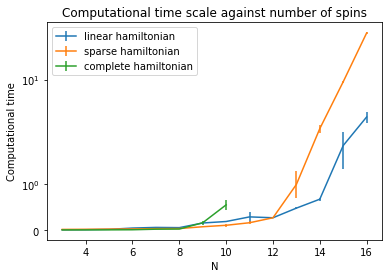

In [ ]:
plt.errorbar(list(Ns)+list(Ns_extra), [time.average for time in timingCompact[1]], [time.stdev for time in timingCompact[1]], label='linear hamiltonian')
plt.errorbar(list(Ns)+list(Ns_extra), [time.average for time in timingCompact[2]], [time.stdev for time in timingCompact[2]], label='sparse hamiltonian')
plt.errorbar(Ns, [time.average for time in timingCompact[0]], [time.stdev for time in timingCompact[0]], label='complete hamiltonian')
plt.legend()
plt.title('Computational time scale against number of spins')
plt.xlabel('N')
plt.ylabel('Computational time')
plt.yscale('symlog')

We can see that at small N the computation time is similar for three method but then around N=9 complete hamiltonian startd to grow exponentially. Then at N=13, sparse hamiltonian grow more rapidly compared to linear hamiltonian. Note that at around 10 to 12 dimension, linear method is actully less efficient than sparse matrix.

## Part 4: Magnetization - Optional!
Now that we have efficient ways of finding our groundstate, we can turn to look at how the magnetisation of the groundstate depends on $h$ and $N$. 

### Task 10:
Using a sparse matrix, define a function that computes the expectation value of the magnetisation along the $x$-axis given a state vector. The magnetisation operator is 
$$ m^x = \frac{1}{N}\sum_{i=1}^N \sigma_i^x $$

Measure and plot $\langle m^x \rangle$ in the groundstate. 

Note: For small $h$ you may find that you have a pair of degenerate groundstates. You will have to account for this appropriately. 

In [ ]:
def ExpValueMx( N, h ):
    # Your code goes here
    H = sparse.csr_matrix(np.zeros((2**N, 2**N)))
    for i in range(N):
      H += ft.reduce(sparse.kron, [sparse.identity(2**i), sparseX, sparse.identity(2**(N-i-1))]) 
    m_x = H/N
    expVal = []
    for i in range(len(h)):
      psi = spsl.eigsh(SparseHamiltonian(N, h=h[i]), k=1, which='SA')[1]
      expVal.append((psi.transpose() @ m_x @ psi)[0][0])
    return expVal

In [ ]:
ExpValueMx(3,[1,1.1])

[0.6666666666666665, 0.7129965316343334]

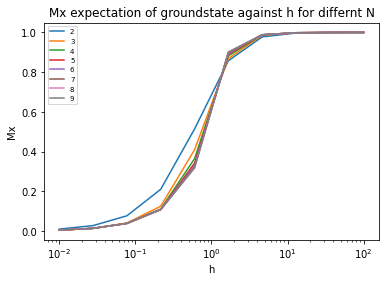

In [ ]:
hh = np.logspace(-2, 2, 10)
Ns = np.arange(2, 10, 1)

for N in Ns:
  E = ExpValueMx(N,hh)
  plt.plot(hh, E, label=str(N))
  plt.legend(prop={'size': 7})
  plt.title('Mx expectation of groundstate against h for differnt N')
  plt.xlabel('h')
  plt.ylabel('Mx')
  plt.xscale('log')

### Task 11:
What about the magnetization along the $z$-axis? This operator is defined by 
$$ m^z = \frac{1}{N}\sum_{i=1}^N \sigma_i^z $$

Write a function that uses tensor operations to act with $m^z$ on a state. (This should look something like the function "ActWithH" we defined above.)

Use this to measure and plot $\langle m^z \rangle$ as a function of $h$ in the groundstate.

In [ ]:
def ActWithmZ(psi, N):
  
    # Your code goes here.
    hloc = - (1/N) * np.kron(sigmaZ, I).reshape((2,2,2,2))
    # hloc = LocalHamiltonian(h).reshape((2,2,2,2))
    d = hloc.shape[0]
    psiOut = np.zeros(psi.size)
    for k in range(N - 1):
    # apply local Hamiltonian terms to sites [k,k+1]
        psiOut += np.tensordot(hloc.reshape(d**2, d**2),
                           psi.reshape(d**k, d**2, d**(N - 2 - k)),
                           axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)

    # apply periodic term
    psiOut += np.tensordot(hloc.reshape(d, d, d, d),
                           psi.reshape(d, d**(N - 2), d),
                           axes=[[2, 3], [2, 0]]
                           ).transpose(1, 2, 0).reshape(d**N)

    return psiOut  

In [ ]:
def ExpValueMz(N, h):
    # Your code goes here.
    expVal = []
    for i in range(len(h)):
      psi = spsl.eigsh(LinearHamiltonian(N, h=h[i]), k=2, which='SA')[1]
      e1 = psi[:,0].transpose() @ ActWithmZ(psi[:,0], N)
      e2 = psi[:,1].transpose() @ ActWithmZ(psi[:,1], N)
      expVal.append(0.5*(e1+e2))
    return expVal


In [ ]:
ExpValueMz(3, [0])

[-1.6653345369377348e-16]

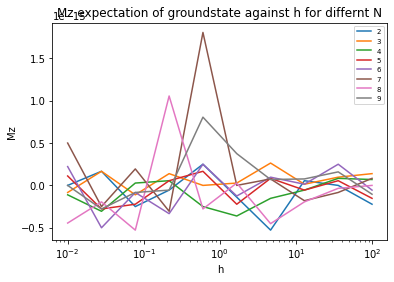

In [ ]:
hh = np.logspace(-2, 2, 10)
Ns = np.arange(2, 10, 1)

for N in Ns:
  E = ExpValueMz(N,hh)
  plt.plot(hh, E, label=str(N))
  plt.legend(prop={'size': 7})
  plt.title('Mz expectation of groundstate against h for differnt N')
  plt.xlabel('h')
  plt.ylabel('Mz')
  plt.xscale('log')

### Task 12:
$\langle m^z \rangle$ does not look particularly exciting in the ground state. Can you add a small perturbation to your Hamiltonian so that the ground state of the chain is the all-up state in the $h\to 0$ limit? Make a new function below to construct the perturbed Hamiltonian, and make another plot of $\langle m^z \rangle$.

In [ ]:
def LocalHamiltonian_pert(h, g):
    # Your code goes here
    Hloc = -np.kron(sigmaZ, sigmaZ) - (1/2) * h * (np.kron(sigmaX, I) + np.kron(I, sigmaX)) + g * np.kron(sigmaZ, I)
    return Hloc

def ActWithH_pert(psiIn, N, h=1. , g=1.):
    
    hloc = LocalHamiltonian_pert(h, g).reshape((2,2,2,2))
    d = hloc.shape[0]
    psiOut = np.zeros(psiIn.size)
    for k in range(N - 1):
    # apply local Hamiltonian terms to sites [k,k+1]
        psiOut += np.tensordot(hloc.reshape(d**2, d**2),
                           psiIn.reshape(d**k, d**2, d**(N - 2 - k)),
                           axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)

    # apply periodic term
    psiOut += np.tensordot(hloc.reshape(d, d, d, d),
                           psiIn.reshape(d, d**(N - 2), d),
                           axes=[[2, 3], [2, 0]]
                           ).transpose(1, 2, 0).reshape(d**N)

    return psiOut  

def LinearHamiltonian_pert(N, h=1, g=1):
  def Act(psiIn):
    return ActWithH_pert(psiIn, N=N, h=h, g=g)
  H = spsl.LinearOperator((2**N, 2**N), matvec=Act)
  return H

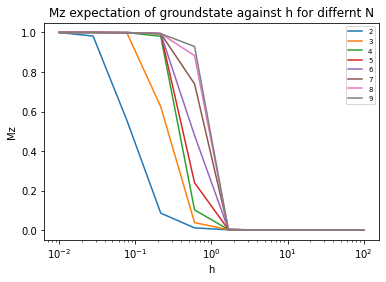

In [ ]:
def ActWithmZ_pert(psi, N, h):
  
    # Your code goes here.
    hloc = - (1/N) * np.kron(sigmaZ, I).reshape((2,2,2,2))
    # hloc = LocalHamiltonian(h).reshape((2,2,2,2))
    d = hloc.shape[0]
    psiOut = np.zeros(psi.size)
    for k in range(N - 1):
    # apply local Hamiltonian terms to sites [k,k+1]
        psiOut += np.tensordot(hloc.reshape(d**2, d**2),
                           psi.reshape(d**k, d**2, d**(N - 2 - k)),
                           axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)

    # apply periodic term
    psiOut += np.tensordot(hloc.reshape(d, d, d, d),
                           psi.reshape(d, d**(N - 2), d),
                           axes=[[2, 3], [2, 0]]
                           ).transpose(1, 2, 0).reshape(d**N)

    return psiOut  

def ExpValueMz_pert(N, h, g):
    # Your code goes here.
    expVal = []
    for i in range(len(h)):
      psi = spsl.eigsh(LinearHamiltonian_pert(N, h=h[i], g=g), k=1, which='SA')[1]
      e = psi.transpose() @ ActWithmZ_pert(psi.transpose()[0], N, h[i])
      expVal.append(e[0])
    return expVal

hh = np.logspace(-2, 2, 10)
Ns = np.arange(2, 10, 1)
g = 0.001
for N in Ns:
  E = ExpValueMz_pert(N,hh, g)
  plt.plot(hh, E, label=str(N))
  plt.legend(prop={'size': 7})
  plt.title('Mz expectation of perturbed groundstate against h for differnt N (g = 0.01)')
  plt.xlabel('h')
  plt.ylabel('Mz')
  plt.xscale('log')